# Rosetta Zoo OSIRIS NAC database
This notebook indexes downloaded OSIRIS PDS3 labels according to a configuration file specifying which attributes to scrape. We then do some cleaning, add browse and data product download links and export to a CSV.

In [52]:
from pds3_utils import Database
from IPython.display import Image
from astropy.io import fits
import math
import os
import matplotlib.pyplot as plt
import pickle

%matplotlib inline

Note that pds3_utils is not yet released on github!

In [53]:
data_path = '/media/mbentley/b182700e-67bc-47d5-9ee6-a98b2e94c806/rosetta_zoo/labels/'

In [54]:
config_file = '/home/mbentley/Dropbox/work/bepi/software/pds3_utils/example.yml'

In [9]:
# dbase = os.path.join(data_path, 'osinac_l3_meta.pkl')

Extract relevant meta data from all labels, or load from disk (note - this is pretty slow and takes a few hours to run)

In [55]:
meta = Database(files='*.LBL', directory=data_path, config_file=config_file, recursive=True)
meta.list_tables()

In [ ]:
meta = Database(config_file=config_file)
# meta.load_dbase(dbase)

In [58]:
meta.save_dbase(filename='osinac_l3_meta.pkl', directory=data_path)

In [56]:
images = meta.get_table('osiris_nac_zoo')

In [57]:
len(images)

35232

## Data cleaning

### Remove images for which we have no surface intercept meta-data

In [59]:
images = images[~images.surf_int_x.isna()]

In [60]:
len(images)

20576

In [61]:
images.head()

,filename,dataset,mission_id,prod_id,start_time,stop_time,instr_id,surf_int_x,surf_int_y,surf_int_z,distance,sc_altitude,phase_angle,sc_position_x,sc_position_y,sc_position_z,sub_sc_lat,sub_sc_lon
1530,/media/mbentley/b182700e-67bc-47d5-9ee6-a98b2e...,RO-C-OSINAC-2-PRL-67PCHURYUMOV-M05-V3.0,ROSETTA,N20140728T232631337ID20F41.FIT,2014-07-28 23:27:39.407,2014-07-28 23:27:39.767,OSINAC,2.381,0.589,0.296,1908.712,1905.41046,1.39325,658.448,-1537.099,-917.949,45.22284,154.84024
1531,/media/mbentley/b182700e-67bc-47d5-9ee6-a98b2e...,RO-C-OSINAC-2-PRL-67PCHURYUMOV-M05-V3.0,ROSETTA,N20140728T232640116ID20F51.FIT,2014-07-28 23:27:48.186,2014-07-28 23:27:48.586,OSINAC,1.458,0.052,1.253,1907.572,1905.37892,1.36647,658.44,-1537.074,-917.932,45.22274,154.76953
1541,/media/mbentley/b182700e-67bc-47d5-9ee6-a98b2e...,RO-C-OSINAC-2-PRL-67PCHURYUMOV-M05-V3.0,ROSETTA,N20140729T004631316ID20F41.FIT,2014-07-29 00:47:39.388,2014-07-29 00:47:39.748,OSINAC,1.542,-0.491,1.262,1890.209,1888.5232,1.40192,654.183,-1523.087,-908.589,45.16918,116.1833
1862,/media/mbentley/b182700e-67bc-47d5-9ee6-a98b2e...,RO-C-OSINAC-2-PRL-67PCHURYUMOV-M06-V3.0,ROSETTA,N20140801T114936156ID20F82.FIT,2014-08-01 11:50:44.333,2014-08-01 11:50:45.961,OSINAC,0.867,-0.963,0.874,822.988,822.56604,9.03767,388.226,-649.599,-325.182,37.2764,230.8959
1863,/media/mbentley/b182700e-67bc-47d5-9ee6-a98b2e...,RO-C-OSINAC-2-PRL-67PCHURYUMOV-M06-V3.0,ROSETTA,N20140801T115014576ID20F82.FIT,2014-08-01 11:51:22.753,2014-08-01 11:51:24.381,OSINAC,0.864,-0.966,0.872,822.858,822.42797,9.04017,388.192,-649.487,-325.107,37.27404,230.58748


### Remove images > 50km

In [62]:
images = images[images.distance < 50.0]

In [63]:
len(images)

10345

## Add image half-width

OSIRIS NAC FOV: 2.2 degrees

In [64]:
nac_fov = 2.2 # degrees

In [65]:
images['half_width'] = math.sin(math.radians(nac_fov)) * images.sc_altitude

## Add browse image links

It would be nice to have a thumbnail URL for each of these so that we can quickly view pairs... We could get this from EPN-TAP, but it's probably easier to simply construct the URL, for example:

https://archives.esac.esa.int/psa/pdap/fileaccess?ID=INTERNATIONALsROSETTAsMISSION/RO-C-OSINAC-2-PRL-67PCHURYUMOV-M06-V3.0/BROWSE/N20140825T204256587ID20F22.JPG

i.e.

https://archives.esac.esa.int/psa/pdap/fileaccess?ID=INTERNATIONALsROSETTAsMISSION/{dataset}/BROWSE/{prod_ud-'.FIT}.JPG

In [66]:
images['browse_url'] = images.apply(lambda row: 
    'https://archives.esac.esa.int/psa/pdap/fileaccess?ID=INTERNATIONALsROSETTAsMISSION/{:s}/BROWSE/{:s}.JPG'.format(row.dataset, row.prod_id[:-4]), axis=1)

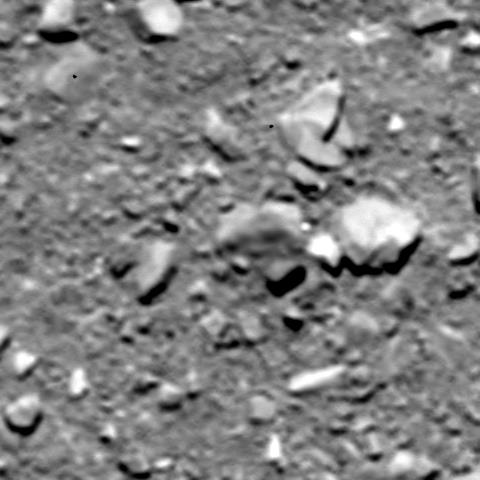

In [67]:
Image(images.browse_url.iloc[-1], width=500) 


## Add data links

There are two ways to do this - use the download URL provided by EPN-TAP:

https://archives.esac.esa.int/psa/pdap/download?CLIENT=epntap&RESOURCE_CLASS=PRODUCT&ID=RO-A-OSINAC-2-AST1-STEINSFLYBY-V1.4:DATA:N20080807T023124677ID20F22

but this would result in a ZIP, or as per the browse image access the files endpoint directly:

In [68]:
images['data_url'] = images.apply(lambda row: 
    'https://archives.esac.esa.int/psa/pdap/fileaccess?ID=INTERNATIONALsROSETTAsMISSION/{:s}/DATA/FIT/{:s}.FIT'.format(row.dataset, row.prod_id[:-4]), axis=1)

Test this to be sure we can extract a FITS file easily...

In [69]:
f = fits.open(images.data_url.iloc[-1])

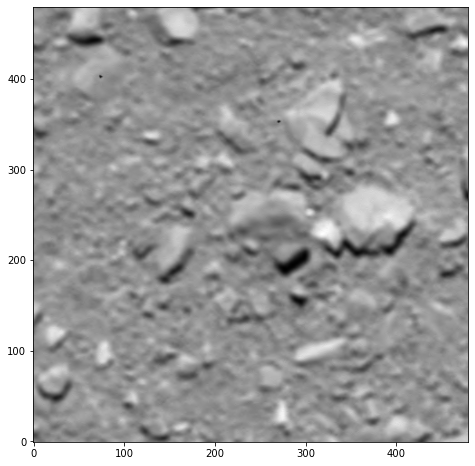

In [70]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.imshow(f[0].data, cmap=plt.cm.gray, origin='lower', interpolation=None)

## Check the fields in one example

In [71]:
images.iloc[0]

filename         /media/mbentley/b182700e-67bc-47d5-9ee6-a98b2e...
dataset                    RO-C-OSINAC-2-PRL-67PCHURYUMOV-M06-V3.0
mission_id                                                 ROSETTA
prod_id                             N20140825T204256587ID20F22.FIT
start_time                              2014-08-25 20:44:05.484000
stop_time                               2014-08-25 20:44:05.564000
instr_id                                                    OSINAC
surf_int_x                                                  -2.427
surf_int_y                                                  -0.836
surf_int_z                                                   0.389
distance                                                    49.385
sc_altitude                                               49.49954
phase_angle                                               37.22603
sc_position_x                                               42.369
sc_position_y                                               -2

# Save the output table

In [72]:
images.to_csv(os.path.join(data_path, 'osinac_metadata.csv.gz'))